In [134]:
from __future__ import division #(for python 2.7 compatibility)
import par
import modes
import spectra
import numpy as np
from numpy import log10, sqrt
import numba
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle


In [131]:
A = np.linspace(par.a0, par.a_rec, 2*par.NT)
K = np.linspace(1,1000,par.NK)

#@numba.njit
def square_basis(NC, theta):
    height = par.NT//NC
    width = par.NK//NC
    out = np.zeros((par.NK, par.NT))
    for i in range(NC**2):
        r,c = i//NC, i%NC
        out[r*width:(r+1)*width, c*height:(c+1)*height] = theta[i]
    out[:,A[::2] < par.a0_pca]=0
    return out

#@numba.njit
def get_square(n, val):
    height = par.NT//par.NC
    width = par.NK//par.NC
    out = np.zeros((par.NK, par.NT))
    r,c = n//par.NC, n%par.NC
    out[r*width:(r+1)*width, c*height:(c+1)*height] = val
    out[:,A[::2] < par.a0_pca]=0
    return out


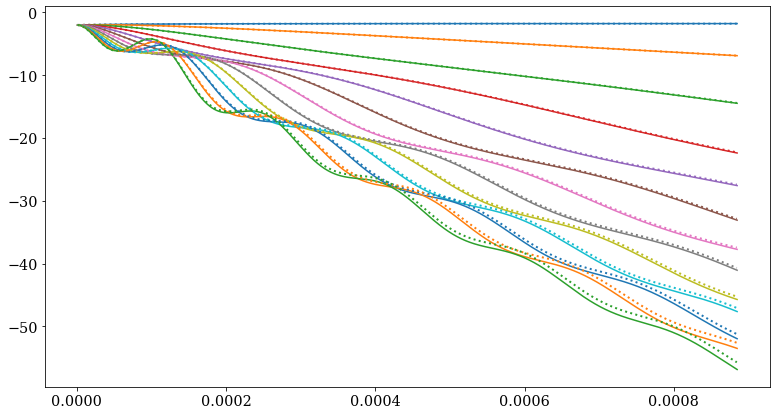

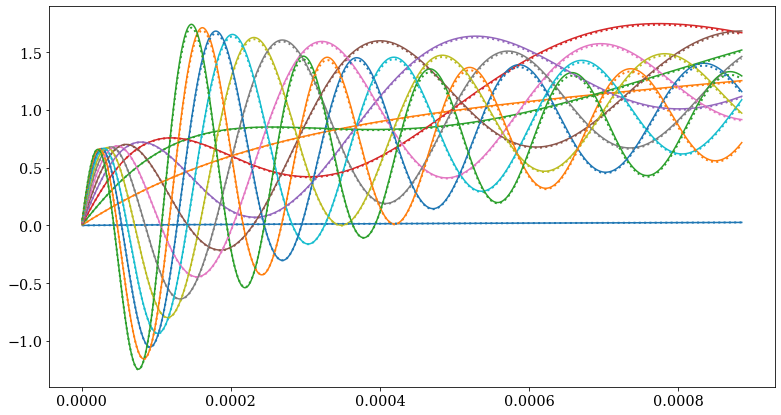

In [2]:
"""Set the A (scale factor) and K (wavenumber) arrays. 
They can be of any length"""
# It is important to remember that the output array is half the size
# of the input array because RK4 is used to solve the ODE.
A = np.linspace(par.a0, par.a_rec, 2*par.NT)
K = np.linspace(1,1000,par.NK)

"""First solve using 3-fluid to get GDM parameters"""
Y3 = modes.solve_3fld(A, K)
Phi3 = Y3[:, 0, :].T
deltaG3 = Y3[:, 1, :].T
vG3 = Y3[:, 2, :].T
deltaC3 =Y3[:, 3, :].T
vC3 = Y3[:, 4, :].T
deltaN3 = Y3[:, 5, :].T
vN3 =Y3[:, 6, :].T

OmegaB = par.OmegaB0 * A[::2]**-3
OmegaC = par.OmegaC0 * A[::2]**-3
OmegaN = par.OmegaN0 * A[::2]**-4
OmegaG = par.OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

# calculate the fiducial GDM functions
wD_F = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC3 + OmegaN*deltaN3)/OmegaD
vD = (OmegaC*vC3 + 4/3*OmegaN*vN3)/((1+wD_F)*OmegaD)
cs2D_F = (deltaN3*OmegaN*1/3)/(deltaD*OmegaD)

plt.rcParams.update(par.plot_params)
# Now the GDM functions can be fed back into 2-fluid:
Y2 = modes.solve_2fld(A[::2], K, wD_F, cs2D_F, deltaD[:,0], vD[:,0])

# eyeball numericall error
plt.plot(A[::2], deltaD.T[:,::20])
plt.gca().set_prop_cycle(None)
plt.plot(A[::4],Y2[:,3,::20], linestyle=':',linewidth=2)
plt.show()

plt.plot(A[::2], vD.T[:,::20])
plt.gca().set_prop_cycle(None)
plt.plot(A[::4],Y2[:,4,::20], linestyle=':',linewidth=2)
plt.show()

C:\Users\Max Aifer\.conda\envs\quantum\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


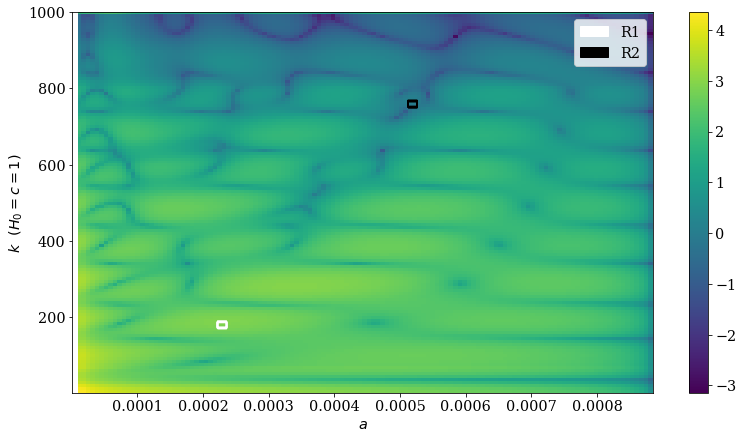

In [145]:
J_128 =  pickle.load(open("data/J_cs2_128.p", "rb"))
F_128 = J_128.T@J_128
infl_128 = log10(sqrt(square_basis(128, np.diag(F_128))))

v1 = get_square(64*11+16,.1)
v2 = get_square(64*48+37,.1)
plt.pcolor(A[::2],K, infl_128)
plt.colorbar()
plt.xlabel(r'$a$')
plt.ylabel(r'$k$  $(H_0 = c = 1)$')
plt.contour(A[::2],K,v1, colors='white')
plt.contour(A[::2],K,v2, colors='black')

R1 = patches.Patch(color='white', label='R1')
R2 = patches.Patch(color='black', label='R2')
plt.legend(handles=[R1,R2])

#plt.legend(['R1','R2'])
plt.show()

Y_v1 = modes.solve_2fld(A[::2], K, wD_F, cs2D_F+v1, deltaD[:,0], vD[:,0])
Y_v2 = modes.solve_2fld(A[::2], K, wD_F, cs2D_F+v2, deltaD[:,0], vD[:,0])
Cl_F = spectra.get_Cl(A[::2], K, wD_F, cs2D_F, deltaD[:,0], vD[:,0])
Cl_v1 = spectra.get_Cl(A[::2], K, wD_F, cs2D_F + v1, deltaD[:,0], vD[:,0])
Cl_v2 = spectra.get_Cl(A[::2], K, wD_F, cs2D_F + v2, deltaD[:,0], vD[:,0])

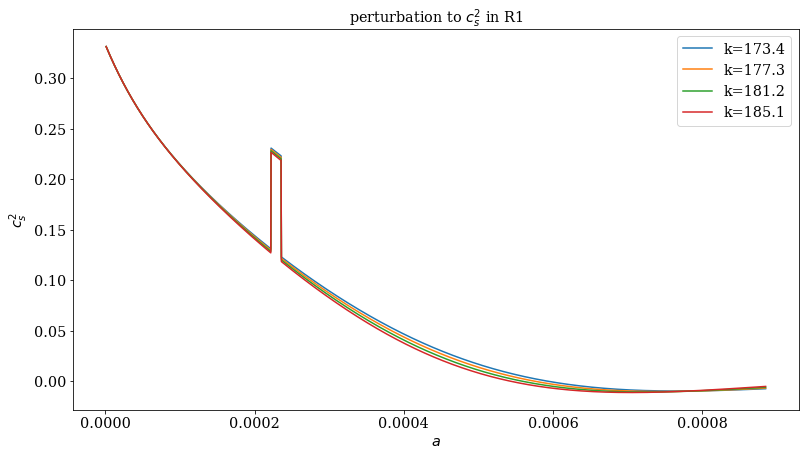

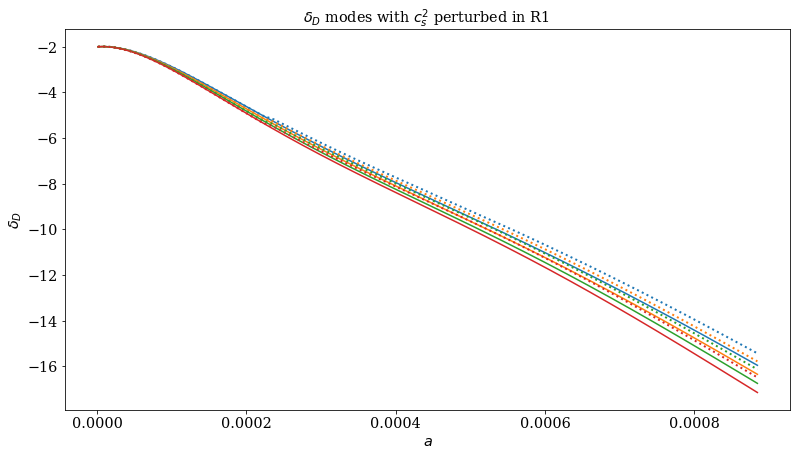

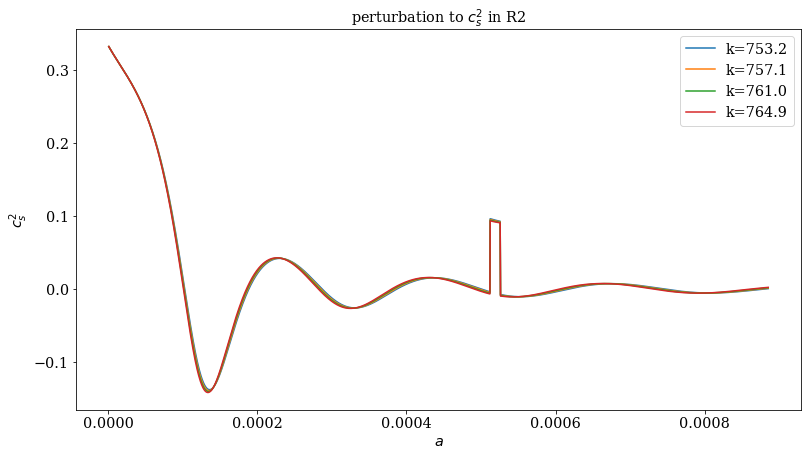

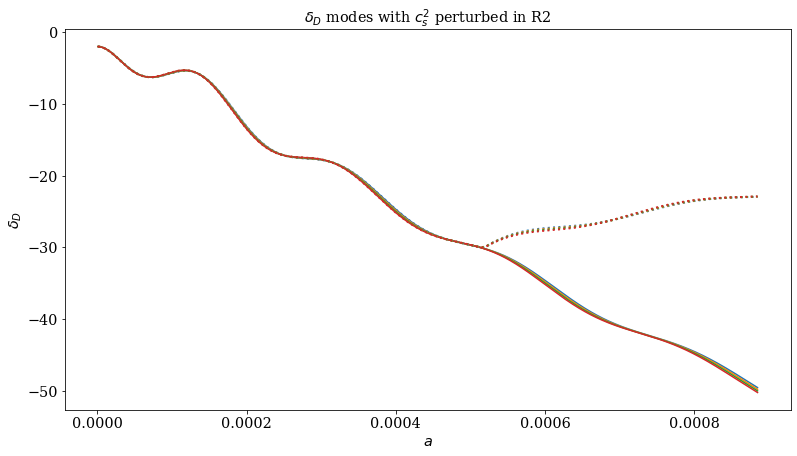

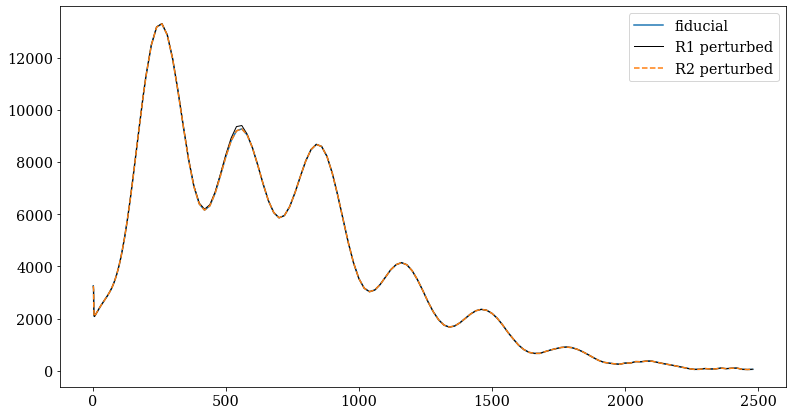

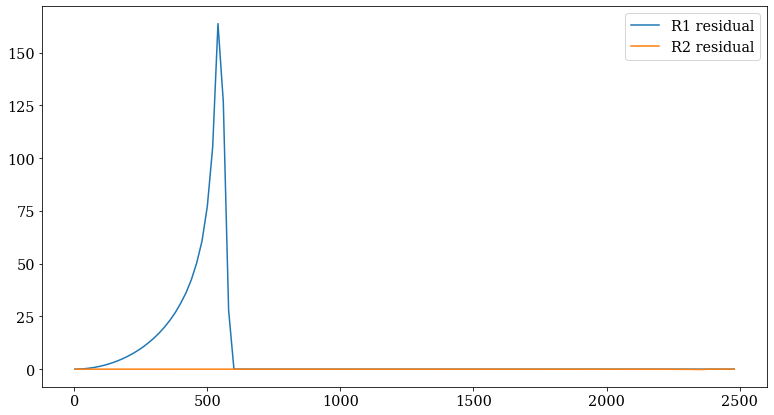

In [156]:

plt.plot(A[::2],(cs2D_F+v1).T[:,44:48])
plt.xlabel(r'$a$')
plt.ylabel(r'$c_s^2$')
plt.title(r'perturbation to $c_s^2$ in R1')
leg = ['k=%.1f'%K[i] for i in range(44,48)]
plt.legend(leg)
plt.show()

plt.plot(A[::4], Y2[:,3,44:48])
plt.gca().set_prop_cycle(None)
plt.plot(A[::4],Y_v1[:,3,44:48], linestyle=':',linewidth=2)
plt.xlabel(r'$a$')
plt.ylabel(r'$\delta_D$')
plt.title(r'$\delta_D $ modes with $c_s^2$ perturbed in R1 ')
plt.show()

plt.plot(A[::2],(cs2D_F+v2).T[:,192:196])
plt.xlabel(r'$a$')
plt.ylabel(r'$c_s^2$')
plt.title(r'perturbation to $c_s^2$ in R2')
leg = ['k=%.1f'%K[i] for i in range(192,196)]
plt.legend(leg)
plt.show()

plt.plot(A[::4], Y2[:,3,192:196])
plt.gca().set_prop_cycle(None)
plt.plot(A[::4],Y_v2[:,3,192:196], linestyle=':',linewidth=2)
plt.xlabel(r'$a$')
plt.ylabel(r'$\delta_D$')
plt.title(r'$\delta_D$ modes with $c_s^2$ perturbed in R2')
plt.show()


plt.plot(spectra.l_list, Cl_F)
plt.plot(spectra.l_list, Cl_v1, color='black',linewidth=1)
plt.plot(spectra.l_list, Cl_v2,linestyle='--')
plt.legend(['fiducial', 'R1 perturbed', 'R2 perturbed'])
plt.show()

plt.plot(spectra.l_list, Cl_v1 - Cl_F)
plt.plot(spectra.l_list, Cl_v2 - Cl_F)
plt.legend(['R1 residual', 'R2 residual'])



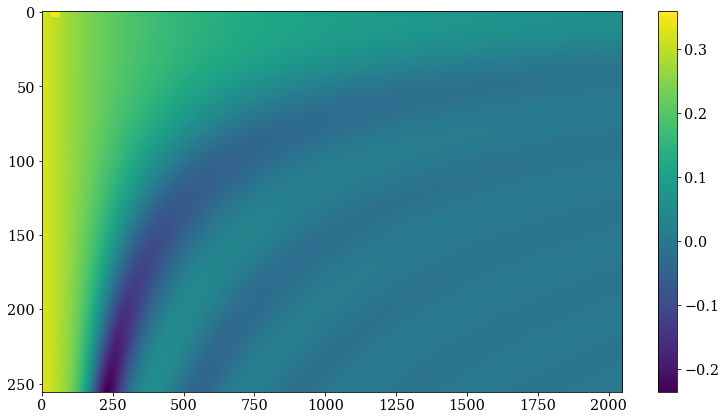

In [4]:
theta_cs2D = np.zeros(par.NC**2)


theta_cs2D[31] = .1
plt.imshow(cs2D_F + get_square(1, 0.05),aspect='auto')
plt.colorbar()

In [ ]:
ss = 0.0001 #(derivative step size)
J = np.zeros((spectra.L, par.NC**2))



for n in range(par.NC**2):
    delta_cs2 = get_square(n, ss)
    Cl_fwd = spectra.get_Cl(A[::2], K, wD_F, 
                            cs2D_F + delta_cs2, deltaD[:,0], vD[:,0])
    Cl_bwd = spectra.get_Cl(A[::2], K, wD_F, 
                            cs2D_F - delta_cs2, deltaD[:,0], vD[:,0])
    J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
    if(n % 10 == 0):
        print(str(n) + ' of ' + str(par.NC**2))
pickle.dump(J, open("data/J_cs2_"+str(par.NC)+".p", "wb"))

0 of 4096
10 of 4096
20 of 4096
30 of 4096
40 of 4096
50 of 4096
60 of 4096
70 of 4096
80 of 4096
90 of 4096
100 of 4096
110 of 4096
120 of 4096
130 of 4096
140 of 4096
150 of 4096
160 of 4096
170 of 4096
180 of 4096
190 of 4096
200 of 4096
210 of 4096
220 of 4096
230 of 4096
240 of 4096
250 of 4096
260 of 4096
270 of 4096
280 of 4096
290 of 4096
300 of 4096
310 of 4096
320 of 4096
330 of 4096
340 of 4096
350 of 4096
360 of 4096
370 of 4096
380 of 4096


In [ ]:

J = pickle.load(open("data/J_cs2_"+str(par.NC)+".p", "rb"))
Sigma = np.diag(Cl_err)


# just using Identity as covariance matrix for now
F = np.transpose(J)@Sigma@J
u, s, v = np.linalg.svd(F)
D, V = np.linalg.eig(F)
# principal vectors are currently defined as the rank-ordered left singular vectors
PV = np.real(u) 
#PC = B@PV
plt.show()
PC = np.zeros((10, par.NK, par.NT))
print(np.shape(PV[:,1]))
for i in range(10):
    PC[i,:,:] = square_basis(PV[:,i])